In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import timeit
import numpy as np

In [2]:


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
class Encoder(nn.Module):
    def __init__(self, n_input=784, n_latent=2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(n_input,512)
        self.mu_encoder = nn.Linear(512, n_latent)
        self.logvar_encoder = nn.Linear(512, n_latent)
        
    def forward(self,x):
        z = torch.flatten(x, start_dim=1)
        z = F.relu(self.fc1(z))
        return self.mu_encoder(z), self.logvar_encoder(z) 
    
class Decoder(nn.Module):
    def __init__(self, n_input=784, n_latent=2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_latent, 512)
        self.fc2 = nn.Linear(512, n_input)
        
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.reshape(-1,1,28,28)
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, n_input=784, n_latent = 2):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(n_input, n_latent)
        self.decoder = Decoder(n_input, n_latent)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self,x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [4]:
def vae_loss(x_recon, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(autoencoder, data, epochs = 20):
    print("Start training")
    start_time = timeit.default_timer()
    opt = torch.optim.Adam(autoencoder.parameters())
    for e in range(epochs):
        epoch_loss = 0
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_recon, mu, logvar = autoencoder(x)
            loss = vae_loss(x_recon, x, mu, logvar)
            loss.backward()
            epoch_loss += loss.mean()
            opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss} Time: {current_time - start_time:.0f}" )
    return autoencoder

In [5]:
latent_dims = 2
input_dims = 784

autoencoder = VariationalAutoencoder(input_dims, latent_dims)

data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)


Start training
Done 0th epoch, Loss: 11179874.0 Time: 11
Done 1th epoch, Loss: 9961585.0 Time: 22
Done 2th epoch, Loss: 9720220.0 Time: 33
Done 3th epoch, Loss: 9571498.0 Time: 45
Done 4th epoch, Loss: 9467022.0 Time: 57
Done 5th epoch, Loss: 9379632.0 Time: 67
Done 6th epoch, Loss: 9314061.0 Time: 77
Done 7th epoch, Loss: 9257101.0 Time: 88
Done 8th epoch, Loss: 9212650.0 Time: 98
Done 9th epoch, Loss: 9170271.0 Time: 108
Done 10th epoch, Loss: 9137482.0 Time: 119
Done 11th epoch, Loss: 9106393.0 Time: 129
Done 12th epoch, Loss: 9076006.0 Time: 139
Done 13th epoch, Loss: 9051967.0 Time: 150
Done 14th epoch, Loss: 9026456.0 Time: 160
Done 15th epoch, Loss: 9006873.0 Time: 170
Done 16th epoch, Loss: 8984651.0 Time: 181
Done 17th epoch, Loss: 8964485.0 Time: 191
Done 18th epoch, Loss: 8950368.0 Time: 201
Done 19th epoch, Loss: 8929085.0 Time: 212


In [6]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        mu, logvar = autoencoder.encoder(x.to(device))
        z = autoencoder.reparameterize(mu, logvar)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:,0], z[:,1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
        plt.savefig('output/vae_distribution.png')

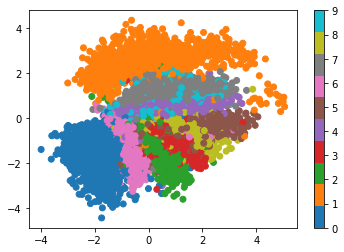

In [7]:
plot_latent(autoencoder,data)

In [8]:


def plot_reconstructed(autoencoder, r0=(-4,4), r1=(-4, 4), n=50):

    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x,y]]).to(device)
            x_recon = autoencoder.decoder(z)
            x_recon = x_recon.reshape(28,28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_recon
    
    plt.figure(figsize = (20,20))
    plt.imshow(img, extent=[*r0,*r1], aspect='auto')
    plt.savefig('output/vae_sampling.png')

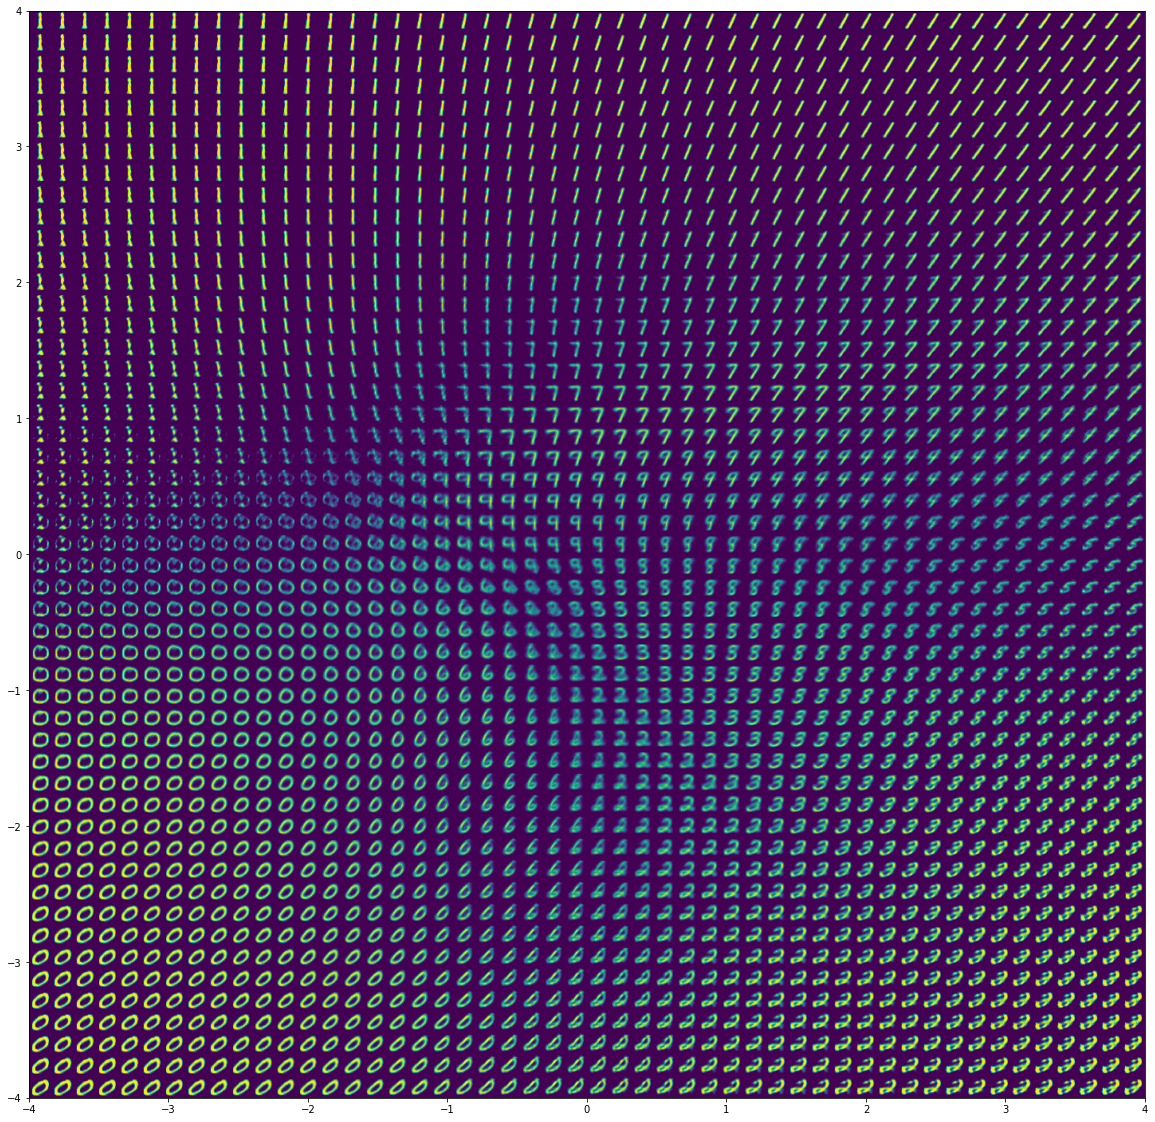

In [9]:
plot_reconstructed(autoencoder)